# Machine learning of ab-initio energy landscapes for crystal structure predictions

Shreyas Honrao, Bryan E. Anthonio, Rohit Ramanathan, Joshua J. Gabriel, Richard G. Hennig

In [1]:
import pickle 
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pickle.load(open("data/cleanedData.pickle", "rb"))
print ("The total number of basin groups are", len(data))
print ("Sample conposition",data[10][0][2])

The total number of basin groups are 673
Sample conposition {'Li': 0.6, 'Ge': 0.4}


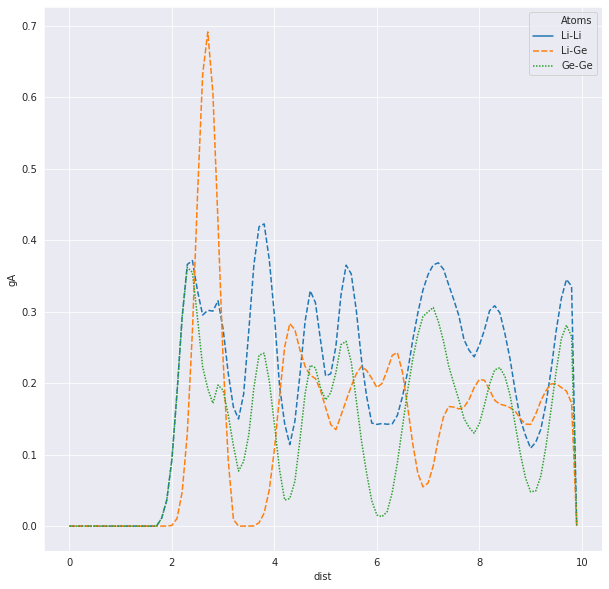

In [3]:
ele = 10
#np.shape(data[0][0][0][0])
atom_composition = []
values = []
distance = []
plotter = pd.DataFrame()

values.extend(data[ele][0][0][0])
atom_composition.extend(['Li-Li']*100)
distance.extend(np.arange(0, 10, 0.1))

values.extend(data[ele][0][0][1])
atom_composition.extend(['Li-Ge']*100)
distance.extend(np.arange(0, 10, 0.1))

values.extend(data[ele][0][0][2])
atom_composition.extend(['Ge-Ge']*100)
distance.extend(np.arange(0, 10, 0.1))

plotter['gA'] = values
plotter['dist'] = distance
plotter['Atoms'] = atom_composition
sns.set_style("darkgrid")
plt.figure(figsize=(10, 10))
ax = sns.lineplot(data=plotter,x='dist',y='gA',hue='Atoms',style='Atoms')
ax.lines[0].set_linestyle("--")
plt.show()

In [4]:
np.random.shuffle(data)

In [5]:
print ("Sample conposition after shuffling",data[0][0][2])

Sample conposition after shuffling {'Li': 0.7142857142857143, 'Ge': 0.2857142857142857}


In [6]:
#Parameters SVR for training and testing. Accoring to the paper

group_train_test_split = 200
c = 5
g = 0.001
eta = 0.01
num_epochs = 50

param_dist = {'C': scipy.stats.expon(scale=c), 'gamma': scipy.stats.expon(scale=g), 'kernel': ['rbf']}


In [7]:
train_group = data[0:group_train_test_split]
test_group = data[group_train_test_split:]

train_group = list(itertools.chain(*train_group))
test_group = list(itertools.chain(*test_group)) 

print (len(train_group),len(test_group))

print (np.shape(train_group))

4257 9911
(4257, 5)


In [16]:
import sklearn
from sklearn.preprocessing import StandardScaler as SS
from sklearn.model_selection import RandomizedSearchCV as CV
from sklearn.svm import SVR


X_train = list(zip(*train_group))[0]
X_train = list( map(np.ndarray.flatten, X_train))
y_train = list(zip(*train_group))[1]


X_test = list(zip(*test_group))[0]
X_test = list( map(np.ndarray.flatten, X_test))
y_test = list(zip(*test_group))[1]


print (np.shape(X_train))


# Feature Scaling
scaler = SS().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

svr = CV(SVR(epsilon=eta), param_distributions=param_dist, cv=5, scoring='neg_mean_squared_error', 
                  n_iter=num_epochs, n_jobs=-1)


print (np.shape(y_train))

clf = svr.fit(X_train,y_train)
print (np.shape(X_test))
clf_best = clf.best_estimator_

y_pred = clf_best.predict(X_test)

print (np.shape(y_test),np.shape(y_pred))


rms = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred))
mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
r2 = sklearn.metrics.r2_score(y_test,y_pred)


print ("The RMS score is in mEV",rms*1000)
print ("The MAE score is in mEV",mae*1000)
print ("The r squared score is", r2)



(4257, 300)
(4257,)
(9911, 300)
(9911,) (9911,)
The RMS score is in mEV 21.40119452752941
The MAE score is in mEV 12.122726603690596
The r squared score is 0.9794978541910693


<Figure size 720x720 with 0 Axes>

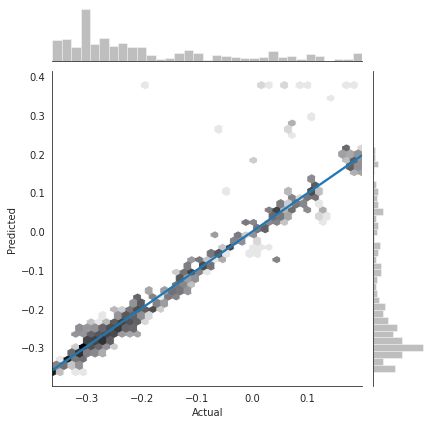

In [23]:
plotter = pd.DataFrame()
plotter['Actual'] = y_test
plotter['Predicted'] = y_pred

sns.set_style("white")
plt.figure(figsize=(10, 10))
g = sns.jointplot(x='Actual', y='Predicted', kind="hex", color="#5d5d60",
                  joint_kws={'gridsize':40, 'bins':'log'}, data=plotter)
ax = sns.regplot(x='Actual', y='Predicted', ax=g.ax_joint, scatter=False,data=plotter)
plt.show()

In [33]:
li_fraction = []
type_value = []
value = []

for i in list(zip(*test_group))[2]:
    li_fraction.append(i['Li'])

plotter = pd.DataFrame()
type_value.extend(['SVR']*len(y_pred))
value.extend(y_pred)
li_fraction.extend(li_fraction)
type_value.extend(['DFT']*len(y_test))
value.extend(y_test)

plotter['Formation Energy'] = value
plotter['Li Fraction'] = li_fraction
plotter['Type of value'] = type_value


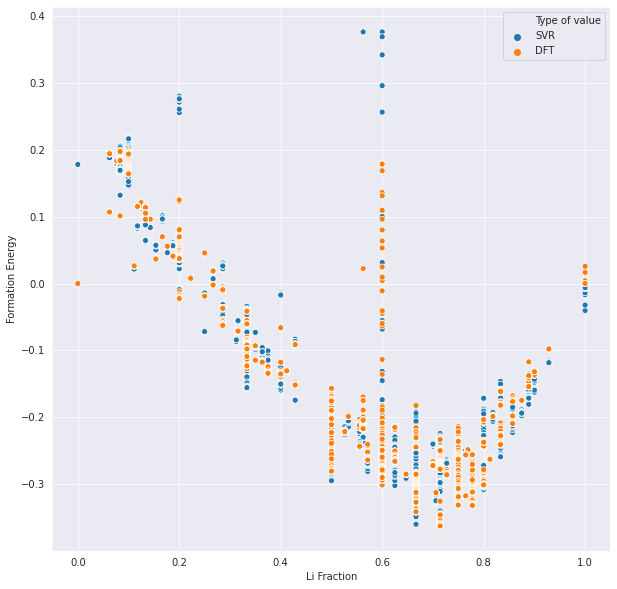

In [37]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(data=plotter,x='Li Fraction',y='Formation Energy',hue='Type of value')
plt.show()

In [65]:
#Parameters KRR for training and testing. Accoring to the paper

group_train_test_split = 200
a = 1
g = 0.05
#eta = 0.01
num_epochs = 5

param_dist = {'alpha': scipy.stats.expon(scale=a), 'gamma': scipy.stats.expon(scale=g)}

gam = scipy.stats.expon(scale=g)


In [66]:
import sklearn
from sklearn.preprocessing import StandardScaler as SS
from sklearn.model_selection import RandomizedSearchCV as CV
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF

X_train = list(zip(*train_group))[0]
X_train = list( map(np.ndarray.flatten, X_train))
y_train = list(zip(*train_group))[1]


X_test = list(zip(*test_group))[0]
X_test = list( map(np.ndarray.flatten, X_test))
y_test = list(zip(*test_group))[1]


print (np.shape(X_train))


# Feature Scaling
scaler = SS().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#kernel = 1.0 * RBF(0.7)

svr = CV(KernelRidge(kernel='rbf'), param_distributions=param_dist, cv=5, scoring='neg_mean_squared_error', 
                  n_iter=num_epochs, n_jobs=-1)


print (np.shape(y_train))

clf = svr.fit(X_train,y_train)
print (np.shape(X_test))
clf_best = clf.best_estimator_

y_pred = clf_best.predict(X_test)

print (np.shape(y_test),np.shape(y_pred))


rms = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred))
mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
r2 = sklearn.metrics.r2_score(y_test,y_pred)


print ("The RMS score is in mEV",rms*1000)
print ("The MAE score is in mEV",mae*1000)
print ("The r squared score is", r2)



(4257, 300)
(4257,)
(9911, 300)
(9911,) (9911,)
The RMS score is in mEV 22.569720660640446
The MAE score is in mEV 15.612859583288722
The r squared score is 0.9771978574372383


<Figure size 720x720 with 0 Axes>

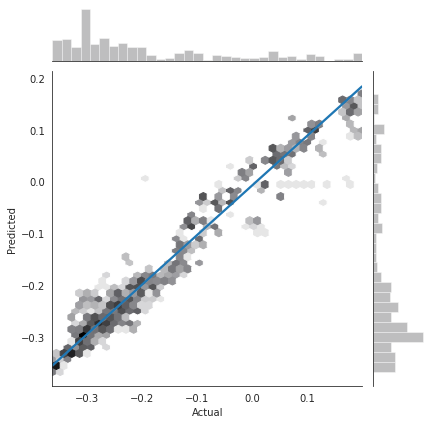

In [67]:
plotter = pd.DataFrame()
plotter['Actual'] = y_test
plotter['Predicted'] = y_pred

sns.set_style("white")
plt.figure(figsize=(10, 10))
g = sns.jointplot(x='Actual', y='Predicted', kind="hex", color="#5d5d60",
                  joint_kws={'gridsize':40, 'bins':'log'}, data=plotter)
ax = sns.regplot(x='Actual', y='Predicted', ax=g.ax_joint, scatter=False,data=plotter)
plt.show()

In [70]:
li_fraction = []
type_value = []
value = []

for i in list(zip(*test_group))[2]:
    li_fraction.append(i['Li'])

plotter = pd.DataFrame()
type_value.extend(['KRR']*len(y_pred))
value.extend(y_pred)
li_fraction.extend(li_fraction)
type_value.extend(['DFT']*len(y_test))
value.extend(y_test)

plotter['Formation Energy'] = value
plotter['Li Fraction'] = li_fraction
plotter['Type of value'] = type_value


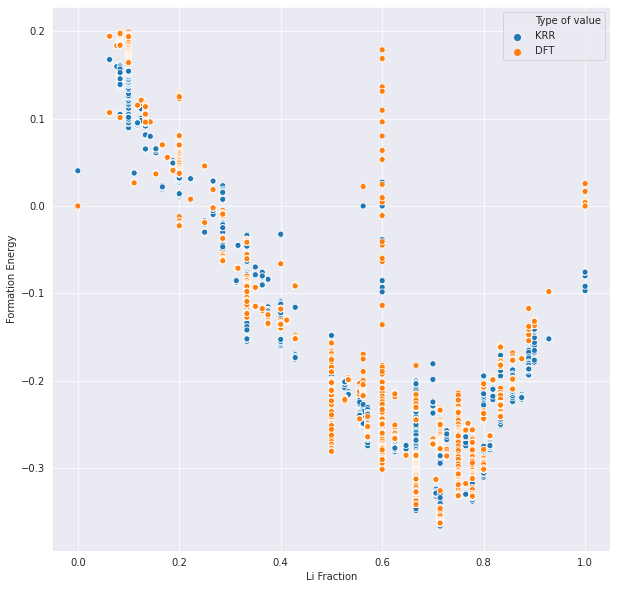

In [71]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(data=plotter,x='Li Fraction',y='Formation Energy',hue='Type of value')
plt.show()

In [76]:
#Parameters SVR for training and testing. Accoring to the paper

group_train_test_split = 200
c = 5
g = 0.001
eta = 0.01
num_epochs = 50

param_dist = {'C': scipy.stats.expon(scale=c), 'gamma': scipy.stats.expon(scale=g), 'kernel': ['rbf']}


In [ ]:
group_train_test_split = 500

size_arr = []
rmse_arr = []

train_group = data[0:group_train_test_split]
test_group = data[group_train_test_split:]

train_group = list(itertools.chain(*train_group))
test_group = list(itertools.chain(*test_group)) 

print (len(train_group),len(test_group))

print (np.shape(train_group))


for size in range(500,8000,50):


    X_train = list(zip(*train_group))[0]
    X_train = list( map(np.ndarray.flatten, X_train[0:size]))
    y_train = list(zip(*train_group[0:size]))[1]


    X_test = list(zip(*test_group))[0]
    X_test = list( map(np.ndarray.flatten, X_test))
    y_test = list(zip(*test_group))[1]


    print (np.shape(X_train))


    # Feature Scaling
    scaler = SS().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    svr = CV(SVR(epsilon=eta), param_distributions=param_dist, cv=5, scoring='neg_mean_squared_error', 
                      n_iter=num_epochs, n_jobs=-1)


    print (np.shape(y_train))

    clf = svr.fit(X_train,y_train)
    #print (np.shape(X_test))
    clf_best = clf.best_estimator_

    y_pred = clf_best.predict(X_test)

    #print (np.shape(y_test),np.shape(y_pred))


    rms = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred))
    mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
    r2 = sklearn.metrics.r2_score(y_test,y_pred)

    rmse_arr.append(rms*1000)
    size_arr.append(size)
#     print ("The RMS score is in mEV",rms*1000)
#     print ("The MAE score is in mEV",mae*1000)
#     print ("The r squared score is", r2)



10557 3611
(10557, 5)
(500, 300)
(500,)
(550, 300)
(550,)
(600, 300)
(600,)
(650, 300)
(650,)
(700, 300)
(700,)
(750, 300)
(750,)
(800, 300)
(800,)
(850, 300)
(850,)
(900, 300)
(900,)
(950, 300)
(950,)
(1000, 300)
(1000,)
(1050, 300)
(1050,)
(1100, 300)
(1100,)
(1150, 300)
(1150,)
(1200, 300)
(1200,)
(1250, 300)
(1250,)
(1300, 300)
(1300,)
(1350, 300)
(1350,)
(1400, 300)
(1400,)
(1450, 300)
(1450,)
(1500, 300)
(1500,)
(1550, 300)
(1550,)
(1600, 300)
(1600,)
(1650, 300)
(1650,)
(1700, 300)
(1700,)
(1750, 300)
(1750,)
(1800, 300)
(1800,)
(1850, 300)
(1850,)
(1900, 300)
(1900,)
(1950, 300)
(1950,)
(2000, 300)
(2000,)
(2050, 300)
(2050,)
(2100, 300)
(2100,)
(2150, 300)
(2150,)
(2200, 300)
(2200,)
(2250, 300)
(2250,)
(2300, 300)
(2300,)
(2350, 300)
(2350,)
(2400, 300)
(2400,)
(2450, 300)
(2450,)
(2500, 300)
(2500,)
(2550, 300)
(2550,)


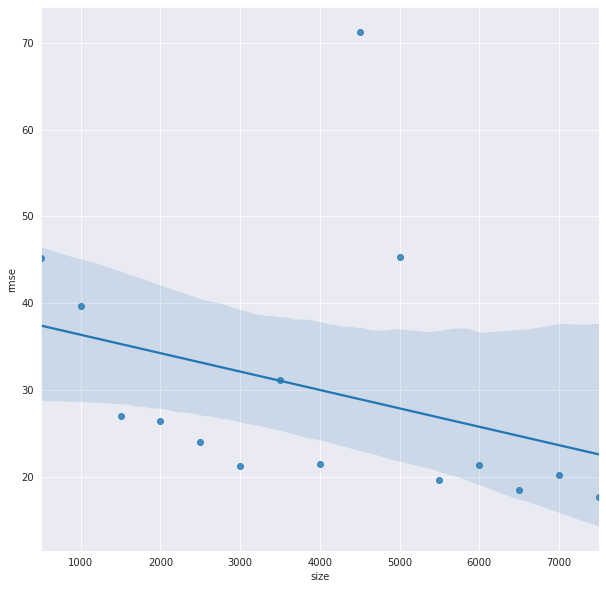

In [80]:
plotter = pd.DataFrame()
plotter['rmse'] = rmse_arr
plotter['size'] = size_arr

sns.set_style("darkgrid")
plt.figure(figsize=(10, 10))
ax = sns.regplot(data=plotter,x='size',y='rmse')
plt.show()